# 内容推荐系统

In [2]:
import pandas as pd
pd.options.display.max_columns = 30
import numpy as np
from math import sqrt
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import random
import matplotlib.pyplot as plt

import os
data_path = os.environ.get('DATA_PATH') + 'AI_Cheats/'

In [3]:
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']

In [5]:
df = pd.read_csv(data_path + 'Seattle_Hotels.csv', encoding='latin-1')

### 数据探索

In [6]:
print(df.head())
print('数据中的酒店个数: {}'.format(len(df)))

                             name  \
0  Hilton Garden Seattle Downtown   
1          Sheraton Grand Seattle   
2   Crowne Plaza Seattle Downtown   
3   Kimpton Hotel Monaco Seattle    
4              The Westin Seattle   

                                           address  \
0  1821 Boren Avenue, Seattle Washington 98101 USA   
1   1400 6th Avenue, Seattle, Washington 98101 USA   
2                  1113 6th Ave, Seattle, WA 98101   
3                   1101 4th Ave, Seattle, WA98101   
4   1900 5th Avenue, Seattle, Washington 98101 USA   

                                                desc  
0  Located on the southern tip of Lake Union, the...  
1  Located in the city's vibrant core, the Sherat...  
2  Located in the heart of downtown Seattle, the ...  
3  What?s near our hotel downtown Seattle locatio...  
4  Situated amid incredible shopping and iconic a...  
数据中的酒店个数: 152


In [7]:
def print_description(index):
    example = df[df.index==index][['desc', 'name']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Name: {}'.format(example[1]))

print_description(10)

Soak up the vibrant scene in the Living Room Bar and get in the mix with our live music and DJ series before heading to a memorable dinner at TRACE. Offering inspired seasonal fare in an award-winning atmosphere, it's a not-to-be-missed culinary experience in downtown Seattle. Work it all off the next morning at FIT®, our state-of-the-art fitness center before wandering out to explore many of the area's nearby attractions, including Pike Place Market, Pioneer Square and the Seattle Art Museum. As always, we've got you covered during your time at W Seattle with our signature Whatever/Whenever® service - your wish is truly our command.
Name: W Seattle


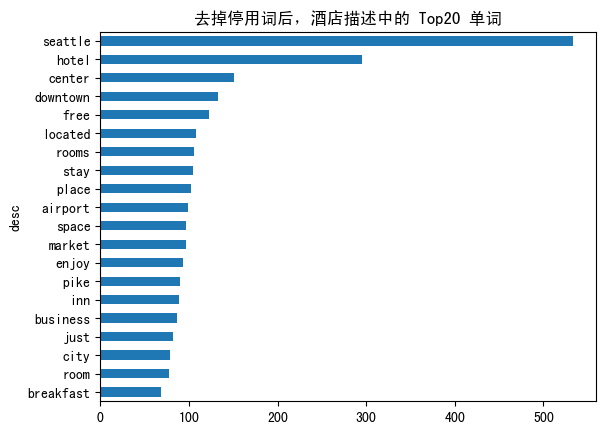

In [8]:
# 得到酒店描述中 n-gram 特征中的 Top-K
def get_top_n_words(corpus, n=1, k=None):
    # 统计 ngram 词频矩阵
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # 按照词频从大到小进行排序
    words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
    return words_freq[:k]

common_words = get_top_n_words(df['desc'], 1, 20)
df1 = pd.DataFrame(common_words, columns=['desc', 'count'])
df1.groupby('desc').sum()['count'].sort_values().plot(kind='barh', title='去掉停用词后，酒店描述中的 Top20 单词')

plt.show()

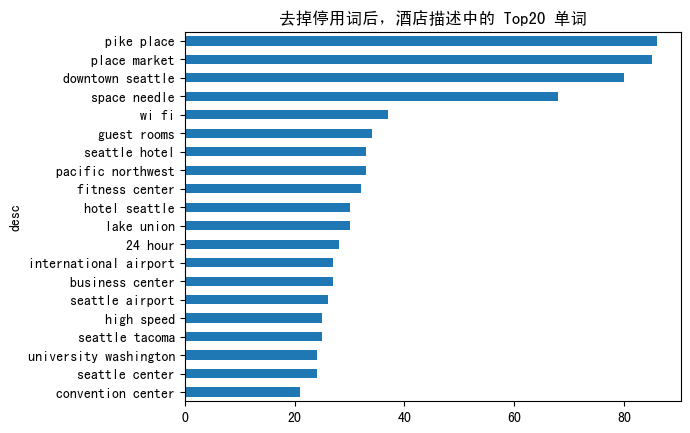

In [9]:
common_words = get_top_n_words(df['desc'], 2, 20)
df1 = pd.DataFrame(common_words, columns=['desc', 'count'])
df1.groupby('desc').sum()['count'].sort_values().plot(kind='barh', title='去掉停用词后，酒店描述中的 Top20 单词')

plt.show()

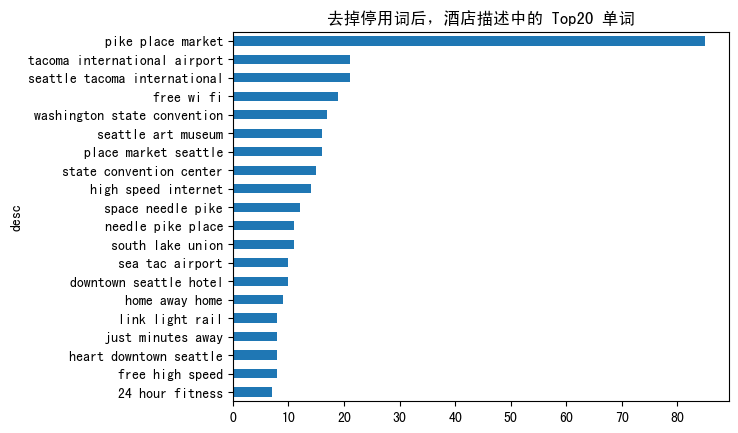

In [10]:
common_words = get_top_n_words(df['desc'], 3, 20)
df1 = pd.DataFrame(common_words, columns=['desc', 'count'])
df1.groupby('desc').sum()['count'].sort_values().plot(kind='barh', title='去掉停用词后，酒店描述中的 Top20 单词')

plt.show()

### 进行推荐

In [11]:
# 加载停用词
STOPWORDS = set(stopwords.words('english'))
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [12]:
# 文本预处理
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

In [13]:
# 对文本进行清晰
def clean_text(text):
    # 全部小写
    text = text.lower()
    # 用空格替代一些特殊符号，如标点
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    # 移出 BAD_SYMBOLS_RE
    text = BAD_SYMBOLS_RE.sub('', text)
    # 从文本中去掉停用词
    text = ' '.join(word for word in text.split() if word not in STOPWORDS )
    return text

df['desc_clean'] = df['desc'].apply(clean_text)
df['desc_clean'].head()

0    located southern tip lake union hilton garden ...
1    located citys vibrant core sheraton grand seat...
2    located heart downtown seattle awardwinning cr...
3    whats near hotel downtown seattle location bet...
4    situated amid incredible shopping iconic attra...
Name: desc_clean, dtype: object

In [14]:
df.set_index('name', inplace=True)

In [15]:
# 建模

# ngram_range=(1, 3) 代表 1-gram + 2-gram + 3-gram
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.01, stop_words='english')
# 针对 desc_clean 提取 tfidf
# fit_transform = fit + transform
tfidf_matrix = tf.fit_transform(df['desc_clean'])
print('TFIDF feature names: {},\n 个数: {}'.format(tf.get_feature_names_out(), len(tf.get_feature_names_out())))

TFIDF feature names: ['000' '000 sq' '000 sq ft' ... 'yummy' 'zones' 'zoo'],
 个数: 3154


In [16]:
print('tfidf_matrix: {}'.format(tfidf_matrix))

tfidf_matrix:   (0, 376)	0.0988145082229999
  (0, 2334)	0.10493558569292807
  (0, 1208)	0.09018733407575145
  (0, 42)	0.08690743468812835
  (0, 2)	0.10493558569292807
  (0, 2179)	0.10493558569292807
  (0, 1777)	0.0940666316769628
  (0, 1170)	0.10493558569292807
  (0, 591)	0.10493558569292807
  (0, 2420)	0.0988145082229999
  (0, 1471)	0.0988145082229999
  (0, 2592)	0.0988145082229999
  (0, 1671)	0.0988145082229999
  (0, 375)	0.0988145082229999
  (0, 169)	0.10493558569292807
  (0, 256)	0.0988145082229999
  (0, 2784)	0.09018733407575145
  (0, 2332)	0.07729044349327371
  (0, 1204)	0.05524527771087949
  (0, 1867)	0.10493558569292807
  (0, 2819)	0.10493558569292807
  (0, 1026)	0.05594295429536109
  (0, 41)	0.0840662566058233
  (0, 2116)	0.10493558569292807
  (0, 404)	0.05818473416407789
  :	:
  (151, 2313)	0.10938920138371673
  (151, 552)	0.06208992001743357
  (151, 1108)	0.0817261625451344
  (151, 238)	0.05578546497360744
  (151, 551)	0.10633117218815535
  (151, 3010)	0.0911256945313327
  (

In [17]:
temp = tfidf_matrix.toarray()
print(temp.shape)
print(tfidf_matrix.shape)

(152, 3154)
(152, 3154)


In [18]:
# 计算酒店之间的余弦相似度（线性核函数）
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_similarities)
print(cosine_similarities.shape)

[[1.         0.0391713  0.10519839 ... 0.04506191 0.01188579 0.02732358]
 [0.0391713  1.         0.06121291 ... 0.06131857 0.01508036 0.03706011]
 [0.10519839 0.06121291 1.         ... 0.09179925 0.04235642 0.05607314]
 ...
 [0.04506191 0.06131857 0.09179925 ... 1.         0.0579826  0.04145794]
 [0.01188579 0.01508036 0.04235642 ... 0.0579826  1.         0.0172546 ]
 [0.02732358 0.03706011 0.05607314 ... 0.04145794 0.0172546  1.        ]]
(152, 152)


In [19]:
indices = pd.Series(df.index) # df.index 是酒店名称
indices[:50]

0                        Hilton Garden Seattle Downtown
1                                Sheraton Grand Seattle
2                         Crowne Plaza Seattle Downtown
3                         Kimpton Hotel Monaco Seattle 
4                                    The Westin Seattle
5                           The Paramount Hotel Seattle
6                                        Hilton Seattle
7                                         Motif Seattle
8                                       Warwick Seattle
9                            Four Seasons Hotel Seattle
10                                            W Seattle
11                                   Gand Hyatt Seattle
12                                 Kimpton Alexis Hotel
13                                            Hotel Max
14                                    Ace Hotel Seattle
15                          Seattle Marriott Waterfront
16                          The Edgewater Hotel Seattle
17                   SpringHill Suites Seattle D

In [20]:
# 基于相似度矩阵和指定的酒店 name，推荐 TOP10 酒店
def recommendations(name, cosine_similarities = cosine_similarities):
    recommended_hotels = []

    # 找到要查询酒店名称的 idx
    idx = indices[indices == name].index[0]
    print('idx: {}'.format(idx))

    # 对于 idx 酒店的余弦相似度向量按照从大到小进行排序。
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)

    # 取相似度最大的前 10 个（除了自己以外）
    top_10_indexes = list(score_series.iloc[1:11].index)

    # 放到推荐列表中
    for i in top_10_indexes:
        recommended_hotels.append(list(df.index)[i])

    return recommended_hotels

In [21]:
recommendations('Hilton Seattle Airport & Conference Center')

idx: 49


['Embassy Suites by Hilton Seattle Tacoma International Airport',
 'DoubleTree by Hilton Hotel Seattle Airport',
 'Seattle Airport Marriott',
 'Motel 6 Seattle Sea-Tac Airport South',
 'Knights Inn Tukwila',
 'Four Points by Sheraton Downtown Seattle Center',
 'Radisson Hotel Seattle Airport',
 'Hampton Inn Seattle/Southcenter',
 'Home2 Suites by Hilton Seattle Airport',
 'Red Lion Hotel Seattle Airport Sea-Tac']

In [22]:
recommendations("The Bacon Mansion Bed and Breakfast")

idx: 116


['11th Avenue Inn Bed and Breakfast',
 'Shafer Baillie Mansion Bed & Breakfast',
 'Gaslight Inn',
 'Bed and Breakfast Inn Seattle',
 'Chittenden House Bed and Breakfast',
 'Hyatt House Seattle',
 'Mozart Guest House',
 'Silver Cloud Hotel - Seattle Broadway',
 'WorldMark Seattle - The Camlin',
 'Pensione Nichols Bed and Breakfast']